## GAN 2D

References
- http://blog.naver.com/atelierjpro/220987973950

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import tensorflow as tf
%matplotlib inline

# Disable GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
NUM_DATA = 10 ** 4
x_real = np.column_stack((np.random.normal(0.25, 0.10, size=NUM_DATA), np.random.normal(-0.5, 0.05, size=NUM_DATA)))

In [3]:
class GAN:
    def __init__(self, dim_z, dim_h1, dim_h2, dim_x):
        self.dim_x = dim_x
        self.dim_h1 = dim_h1
        self.dim_h2 = dim_h2
        self.dim_z = dim_z
        #my_init=tf.truncated_normal_initializer(stddev=0.1)
        my_init=tf.random_uniform_initializer(-1, 1)
        
        # Placeholders
        self.x = tf.placeholder(tf.float32, [None, self.dim_x])
        self.z = tf.placeholder(tf.float32, [None, self.dim_z])
        self.lr = tf.placeholder(tf.float32)
        
        # Generator
        with tf.variable_scope('G'):
            G_h1   = tf.layers.dense(self.z, self.dim_h1, kernel_initializer=my_init, activation=tf.tanh)
            G_h2   = tf.layers.dense(G_h1,   self.dim_h2, kernel_initializer=my_init, activation=tf.tanh)
            self.G = tf.layers.dense(G_h2,   self.dim_x,  kernel_initializer=my_init, activation=tf.tanh)
        
        # Discriminator
        with tf.variable_scope('D') as scope:
            def discriminator(inputs):
                D_h1 = tf.layers.dense(inputs, self.dim_h2, activation=tf.tanh, kernel_initializer=my_init, name='D_h1')
                D_h2 = tf.layers.dense(D_h1, self.dim_h1, activation=tf.tanh, kernel_initializer=my_init, name='D_h2')
                D    = tf.layers.dense(D_h2, 1,          activation=tf.sigmoid, kernel_initializer=my_init, name='D')
                return D
            self.D_real = discriminator(self.x)
            scope.reuse_variables()
            self.D_fake = discriminator(self.G)
        
        # Losses
        self.loss_G      = tf.reduce_mean(-tf.log(self.D_fake))
        self.loss_D_real = tf.reduce_mean(-tf.log(self.D_real))
        self.loss_D_fake = tf.reduce_mean(-tf.log(1 - self.D_fake))
        self.loss_D      = tf.reduce_mean((self.loss_D_real, self.loss_D_fake))
        
        # Optmizers
        def optimizer(loss, var_list):
            return tf.train.AdamOptimizer(self.lr).minimize(loss, var_list=var_list)
        g_params = [v for v in tf.trainable_variables() if v.name.startswith('G/')]
        d_params = [v for v in tf.trainable_variables() if v.name.startswith('D/')]
        self.train_G = optimizer(self.loss_G, g_params)
        self.train_D = optimizer(self.loss_D, d_params)
    
    def generate_noise(self, cnt):
        return np.random.normal(0, 1, size=[cnt, self.dim_z])
    
    def train(self, sess, x, lr, train_D_only=False):
        noise = self.generate_noise(x.shape[0])
        sess.run(self.train_D, feed_dict={self.x: x, self.z: noise, self.lr: lr})
        if not train_D_only:
            sess.run(self.train_G, feed_dict={           self.z: noise, self.lr: lr})
        
    def loss(self, sess, x):
        noise = self.generate_noise(x.shape[0])
        loss_G = sess.run(self.loss_G, feed_dict={           self.z: noise})
        loss_D = sess.run(self.loss_D, feed_dict={self.x: x, self.z: noise})
        return loss_G, loss_D
    
    def generate_data(self, sess, noise):
        return sess.run(self.G, feed_dict={self.z: noise})

In [4]:
def plot_data(x_real, x_fake, path=None):
    plt.ioff()
    plt.rc('font', size=20)
    f, ax = plt.subplots(figsize=(10, 10))
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.plot(x_real[:,0], x_real[:,1], 'bo', markersize=5, markeredgewidth=0.0, alpha=0.1, label='real data (blue)')
    plt.plot(x_fake[:,0], x_fake[:,1], 'ro', markersize=5, markeredgewidth=0.0, alpha=0.1, label='generated data (red)')
    plt.title(r'GAN for 2D Data')
    plt.axis([-1, 1, -1, 1])
    plt.grid(True)
    legend = ax.legend(loc='upper center')
    path == None and plt.show() or plt.savefig(path, bbox_inches='tight')
    plt.close()

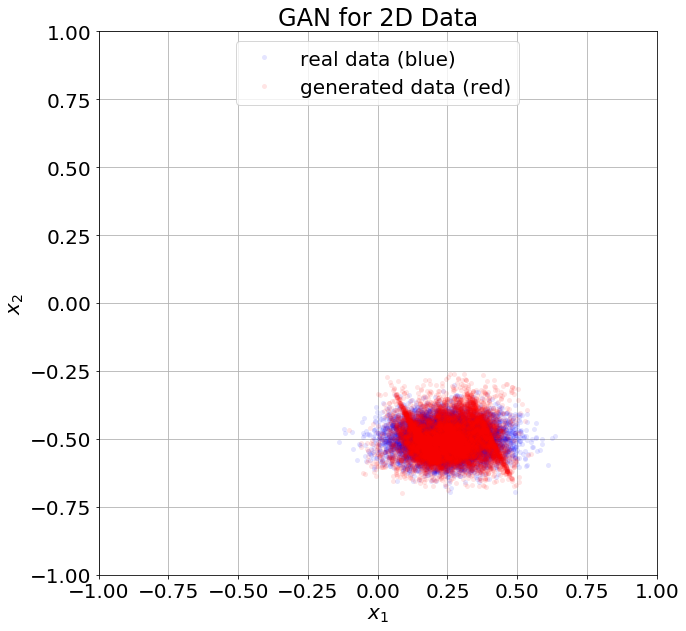

In [5]:
tf.reset_default_graph()

with tf.Session() as sess:
    gan = GAN(dim_z=2**5, dim_h1=2**4, dim_h2=2**3, dim_x=2)
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    fixed_noise = gan.generate_noise(NUM_DATA)
        
    # Train both D and G
    BATCH_SIZE = 2 ** 6
    NUM_ITER = 100001
    num_img = 1
    for iter in xrange(NUM_ITER):
        x_batch = x_real[[random.randint(a=0, b=x_real.shape[0]-1) for _ in range(BATCH_SIZE)]]
        lr = 0.0001 * (1 - float(iter) / NUM_ITER)
        gan.train(sess, x_batch, lr, train_D_only=True)
        if iter % 5 == 0:
            gan.train(sess, x_batch, lr)
        
        # Animation
        if iter % 100 == 0:
            x_fake = gan.generate_data(sess, fixed_noise)
            plot_data(x_real, x_fake, 'plot_gan2d_circle/%d.png'%num_img)
            num_img += 1
         
        # Last generation
        if iter == (NUM_ITER-1):
            x_fake = gan.generate_data(sess, fixed_noise)
            plot_data(x_real, x_fake)